## **Imports**

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import re
from tqdm import tqdm
from umap import UMAP
import paths_ml_task_1 as PATHS

# **Impact of Speech Length on Party Classification Performance**

**TL;DR:** This experiment investigates the extent to which **speech length and contextual depth** affect model performance in a party classification task. We use both transformer-based (BERT) and traditional machine learning models (SVM) on the same dataset and splits, highlighting the semantic limitations of short speech inputs.

---


## **Assumptions**

- The task of party classification relies on learning **semantically distinctive patterns** characteristic of political parties. Such patterns are more likely to emerge in **longer speeches**, which typically feature extensive party-specific rhetoric and structured arguments.
- **Short speeches** tend to contain procedural phrases, interjections, or formal greetings, that carry little to no party-specific information and hinder generalization.
- **Hypotheses:** Models trained on longer speeches generalize better, achieving higher classification performance on test sets. Short speeches lack sufficient party-distinctive semantic context, limiting the model’s ability to effectively learn party-specific language patterns as discriminative features.


---


## **Experimental Design**


### **Dataset Configuration:**

- **Data Source for all models:** All speeches from the 20th electoral term, taken from the `speech_content` column of `data/dataFinalStage/speechContentFinalStage/speech_content_20.pkl`.
>**Data Preprocessing:**
>- **Merging factions:** Speeches of **BSW** are merged into **DIE LINKE.** due to their semantic similarity and limited data availability for individual analysis as shown in the [`BSW` Confusion Experiment](ML-Task-1_Classification_Experiments.ipynb).
>- **Removal of contributions:** As explained before, artificial placeholders (`({x})`) indicating the positions of interjections or comments (\"contributions\") were inserted during initial [Data Generation](../dataGeneration/dataGenerationPipeline/dataGenerationPipeline_1.ipynb) to facilitate their reinsertion. These contribution position markers carry no semantic information and are therefore removed.
- **Class Selection:**
    - Unassigned speeches with `faction_id=-1` as well as speeches by `Fraktionslos` with `faction_id=18` are removed.
    - The final 6 class labels are `AfD`, `Bündnis 90/Die Grünen`, `CDU/CSU`, `DIE LINKE`, `FDP` and `SPD`.
- **Sampling Strategy (stratified by faction):** Per speech token counts are computed using the `bert-base-german-cased` tokenizer. Then speeches are filtered based on their respective length and the dataset is split:
    - **SHORT:** Speeches with `< 128` tokens (for the SHORT models)
    - **LONG:** Speeches with `320–512` tokens (for the LONG models)
    - Both subsets (SHORT and LONG) undergo stratified sampling, selecting an equal number of speeches per faction, constrained by the smallest available faction count..
- **Train-Test Split:** One stratified 80/20 split with fixed random seed for reproducibility is used for **all models**. The trained models are evaluated on the 20 % hold-out set.


### **Models:**

- We compare two variants of the **bert-base-german-cased** model trained under identical conditions, differing only in input length: `BERT_LONG` and `BERT_SHORT`
    - BERT is a **context-aware transformer** model that is generally known to handle raw unprocessed text without extensive preprocessing very well.
    - Since the objective is to isolate the impact the **amount of available context** has on semantic learning, BERT serves as an ideal model due to its robust embedding capabilities without any need for extensive preprocessing which might impact the available context.
- Additionally, two SVM classifiers trained on TF-IDF representations of the same short and long speech subsets serve as a baselines to validate the BERT-based findings and contrast the results obtained by the more complex BERT models: `SVM_LONG` and `SVM_SHORT`

| Input Length                     | Description                          | Samples per faction (approx.) | Total samples (approx.) | Deep Learning Model | Classic Validation Model |
|----------------------------------|--------------------------------------|-------------------------------|-------------------------|---------------------|--------------------------|
| 320–512 tokens (1600-2560 chars) | Long speech input, extensive context | 250                           | 1800                    | `BERT_LONG`         | `SVM_LONG`               |
| < 128 tokens (< 640 chars)       | Short speech input, limited context  | 250                           | 1800                    | `BERT_SHORT`        | `SVM_SHORT`              |


#### **Model Architectures and Their Role in This Experiment:**

- The two modeling paradigms — BERT and SVM — not only provide predictive benchmarks but also different lenses on the role of context within our comparative framework: lexical (SVM) vs. semantic-compositional (BERT)
- BERT-Based Classifiers (using the [CLS] token representation) leverage deep contextualized embeddings to model word meaning dynamically based on surrounding text. The key hypothesis tested is whether longer sequences enable the model to form richer, more party-distinctive embeddings through access to complete rhetorical patterns and policy-specific framing. In contrast, BERT_SHORT is expected to operate under semantic under-specification, making it vulnerable to ambiguities and generic language.
- SVM Classifiers on TF-IDF Features serve as high-bias, low-variance baselines. They rely solely on word frequency patterns without any notion of contextual embedding. By including them, we assess whether long speeches intrinsically carry more linearly separable lexical signals—even without context modeling. If performance gains observed with BERT_LONG are mirrored in SVM_LONG, it would suggest that the performance uplift is partially due to richer vocabulary alone. If not, it underscores the importance of context-sensitive modeling in capturing discourse-level party signals.


#### **Shared Hyperparameters and Configuration for BERT_SHORT and BERT_LONG to ensure comparability:**

- **Model:** `bert-base-german-cased` from HuggingFace Transformers
- **Tokenizer:** `BertTokenizer` (with ``padding = max speech length of the respective model (SHORT=128, LONG=512)` and ``truncation=True` to enforce hard input-length limits)
- **Training Hyperparameters for both models:**
  - Epochs: 3
  - Batch size: 8
  - Learning rate: 1e-5
  - Evaluation strategy: `epoch`
  - Fixed `random_seed` (`SEED = 42`)


#### **Additional Validation: Configuration of the TF-IDF based SVM models:**

- **Model:** Linear Support Vector Machine (`LinearSVC` classifier from scikit-learn with a fixed `random_state=42`)
- **TF-IDF Vectorizer Settings:**
  - `ngram_range=(1, 3)` → unigrams to trigrams
  - `max_features=50000`
  - `min_df=3` → removes very rare words
  - `max_df=0.5` → removes overly frequent, generic words
- **Additional Preprocessing of speech text:** Light preprocessing (lowercasing speech texts in addition to the already removed contribution position markers) helps reduce noise in TF-IDF vectors without harming interpretability. (Note: TF-IDF vectors become very sparse with short samples.)


---


## **Evaluation Strategy**

### **Quantitative Metrics:**

- **Macro-F1 Score** serves as our principal metric due to the balanced class structure induced by stratified sampling. In this context, it helps verify whether semantic patterns are equally learnable across parties — especially in shorter speech samples where contextual information is sparse.
- **Accuracy** provides a complementary global measure of overall classification correctness.
- **Per-Class Precision and Recall** illuminate model performance at a **class-specific level**. High precision but low recall, for instance, would indicate conservative predictions, potentially due to ambiguous or generic language. These metrics thus aid in identifying asymmetries in linguistic distinctiveness between parties, which may be more pronounced in short speech settings.
- **Confusion Matrices** enable visual inspection of inter-class confusion patterns. We anticipate that short speeches, due to their limited contextual depth, will yield more symmetric confusion matrices, especially among ideologically adjacent parties. In contrast, long speeches are expected to generate sharper diagonals, indicating stronger discriminative signals.

### **Qualitative Insights:**

- **Top-3 Predictions** (BERT only) are examined to gauge model uncertainty and semantic neighborhood structure.
- **Supervised UMAP Embeddings** of the final hidden layer (BERT only) are employed to visualize how clearly the model's internal representations cluster by party. These visualizations serve as a proxy for class separability in latent space and can reveal whether short speeches lead to semantic entanglement across classes.
- **Top TF-IDF Features per Class** (only SVM) reveal which tokens are most discriminative. In long speeches, we expect ideologically and policy-relevant terms (e.g., "Grundrente", "Klimaziel"), while short speeches may show procedural artifacts (e.g., "Herr Präsident", "Danke").

Counting tokens: 100%|██████████| 32042/32042 [01:20<00:00, 396.97it/s]
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:521: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_short_sample = df_short.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=MIN_SAMPLES, random_state=SEED))
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:522: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns afte


[INFO] Distribution of short speeches (<128 tokens) before sampling:
faction_abbreviation
AfD                      1234
Bündnis 90/Die Grünen    1435
CDU/CSU                  2662
DIE LINKE.                431
FDP                      1060
SPD                      1643
Name: count, dtype: int64

[INFO] Distribution of long speeches (320–512 tokens) before sampling:
faction_abbreviation
AfD                      243
Bündnis 90/Die Grünen    383
CDU/CSU                  548
DIE LINKE.               511
FDP                      265
SPD                      404
Name: count, dtype: int64

[INFO] Distribution of speeches AFTER sampling (for all models): 243 speeches per class.


Map:   0%|          | 0/1166 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:131: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_local = Trainer(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,1.593879,0.384220,0.360392
2,No log,1.229659,0.635506,0.631469
3,No log,1.071213,0.706690,0.703645


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report BERT_SHORT:
                       precision  recall  f1-score  support
AfD                        0.286   0.316     0.300   19.000
Bündnis 90/Die Grünen      0.333   0.421     0.372   19.000
CDU/CSU                    0.286   0.200     0.235   20.000
DIE LINKE.                 0.259   0.368     0.304   19.000
FDP                        0.190   0.200     0.195   20.000
SPD                        0.300   0.150     0.200   20.000
accuracy                   0.274   0.274     0.274    0.274
macro avg                  0.276   0.276     0.268  117.000
weighted avg               0.275   0.274     0.266  117.000

Zehn zufällige Top-3 predictions BERT_SHORT:


,True_Label,Top1_Pred,Top1_Prob,Top2_Pred,Top2_Prob,Top3_Pred,Top3_Prob,Confidence_Gap
0,FDP,CDU/CSU,0.303029,SPD,0.231345,FDP,0.204280,0.071685
1,AfD,DIE LINKE.,0.526331,AfD,0.175345,FDP,0.114051,0.350986
2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,0.394748,SPD,0.272300,FDP,0.224619,0.122448
3,FDP,DIE LINKE.,0.392970,AfD,0.165789,CDU/CSU,0.140567,0.227181
4,AfD,AfD,0.422080,DIE LINKE.,0.184213,CDU/CSU,0.182590,0.237867
5,SPD,Bündnis 90/Die Grünen,0.475313,FDP,0.183474,SPD,0.163422,0.291838
6,CDU/CSU,SPD,0.491577,Bündnis 90/Die Grünen,0.241921,FDP,0.155849,0.249656
7,SPD,CDU/CSU,0.277229,AfD,0.274919,FDP,0.152690,0.002310
8,Bündnis 90/Die Grünen,CDU/CSU,0.271347,AfD,0.232318,DIE LINKE.,0.185080,0.039029
9,FDP,Bündnis 90/Die Grünen,0.408694,FDP,0.256035,SPD,0.201433,0.152659


Confidence Gap (mean) BERT_SHORT: 0.14859568
Confidence Gap (min) BERT_SHORT: 0.0023096204
Confidence Gap (max) BERT_SHORT: 0.5901752
Confidence Gap (var) BERT_SHORT: 0.015717532
Top-1 Hit Rate BERT_SHORT: 0.274
Top-2 Hit Rate BERT_SHORT: 0.496
Top-3 Hit Rate BERT_SHORT: 0.692


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


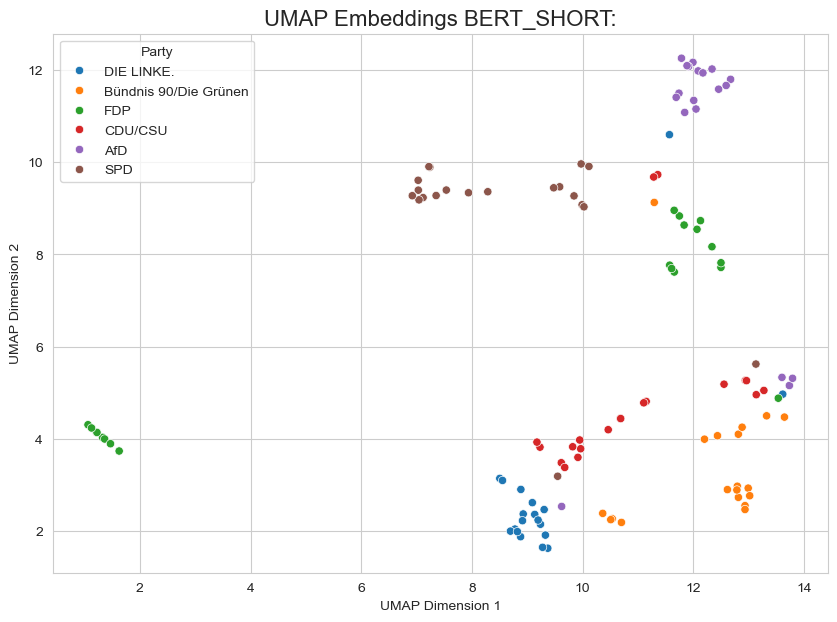

Map:   0%|          | 0/1166 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:131: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_local = Trainer(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,1.414820,0.422813,0.382135
2,No log,1.095046,0.614065,0.610024
3,No log,0.966462,0.671527,0.666865


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report BERT_LONG:
                       precision  recall  f1-score  support
AfD                        0.565   0.684     0.619   19.000
Bündnis 90/Die Grünen      0.286   0.316     0.300   19.000
CDU/CSU                    0.273   0.300     0.286   20.000
DIE LINKE.                 0.667   0.316     0.429   19.000
FDP                        0.280   0.350     0.311   20.000
SPD                        0.471   0.400     0.432   20.000
accuracy                   0.393   0.393     0.393    0.393
macro avg                  0.423   0.394     0.396  117.000
weighted avg               0.421   0.393     0.395  117.000

Zehn zufällige Top-3 predictions BERT_LONG:


,True_Label,Top1_Pred,Top1_Prob,Top2_Pred,Top2_Prob,Top3_Pred,Top3_Prob,Confidence_Gap
0,FDP,AfD,0.275391,SPD,0.192365,Bündnis 90/Die Grünen,0.161552,0.083026
1,AfD,AfD,0.465802,DIE LINKE.,0.353219,CDU/CSU,0.075719,0.112583
2,Bündnis 90/Die Grünen,FDP,0.312505,CDU/CSU,0.282062,Bündnis 90/Die Grünen,0.205156,0.030443
3,FDP,SPD,0.356299,CDU/CSU,0.257099,FDP,0.212540,0.099200
4,AfD,CDU/CSU,0.273381,DIE LINKE.,0.272187,AfD,0.199760,0.001194
5,SPD,Bündnis 90/Die Grünen,0.408755,FDP,0.258755,SPD,0.248758,0.150000
6,CDU/CSU,FDP,0.314358,Bündnis 90/Die Grünen,0.302751,SPD,0.266239,0.011606
7,SPD,FDP,0.332491,Bündnis 90/Die Grünen,0.300680,SPD,0.270358,0.031811
8,Bündnis 90/Die Grünen,SPD,0.265073,CDU/CSU,0.265022,Bündnis 90/Die Grünen,0.237592,0.000051
9,FDP,AfD,0.404128,SPD,0.149126,DIE LINKE.,0.142034,0.255003


Confidence Gap (mean) BERT_LONG: 0.12714548
Confidence Gap (min) BERT_LONG: 5.108118e-05
Confidence Gap (max) BERT_LONG: 0.59275925
Confidence Gap (var) BERT_LONG: 0.017302305
Top-1 Hit Rate BERT_LONG: 0.393
Top-2 Hit Rate BERT_LONG: 0.513
Top-3 Hit Rate BERT_LONG: 0.701


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


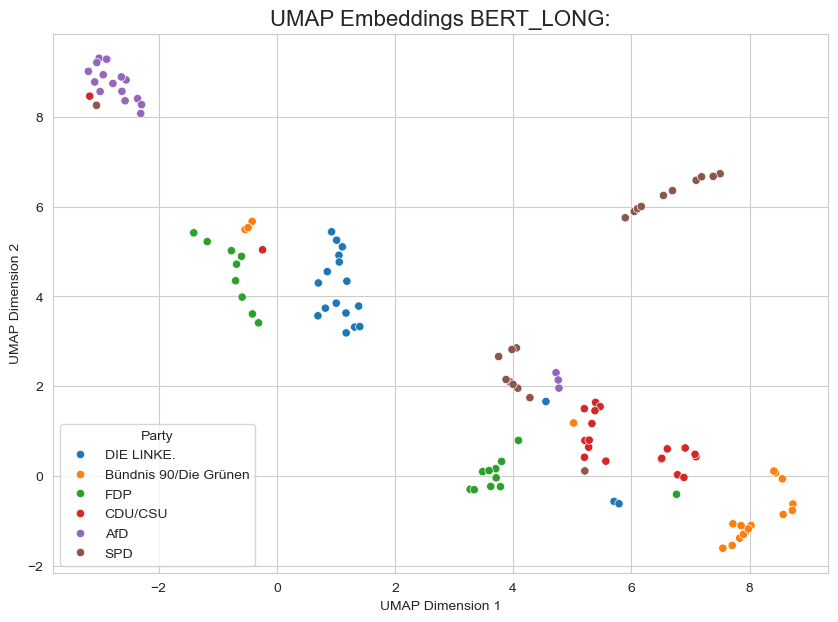

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:590: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="True_Label", y="Confidence_Gap", data=df_top3_model, palette="Set2", ax=axes[i])
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:590: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="True_Label", y="Confidence_Gap", data=df_top3_model, palette="Set2", ax=axes[i])


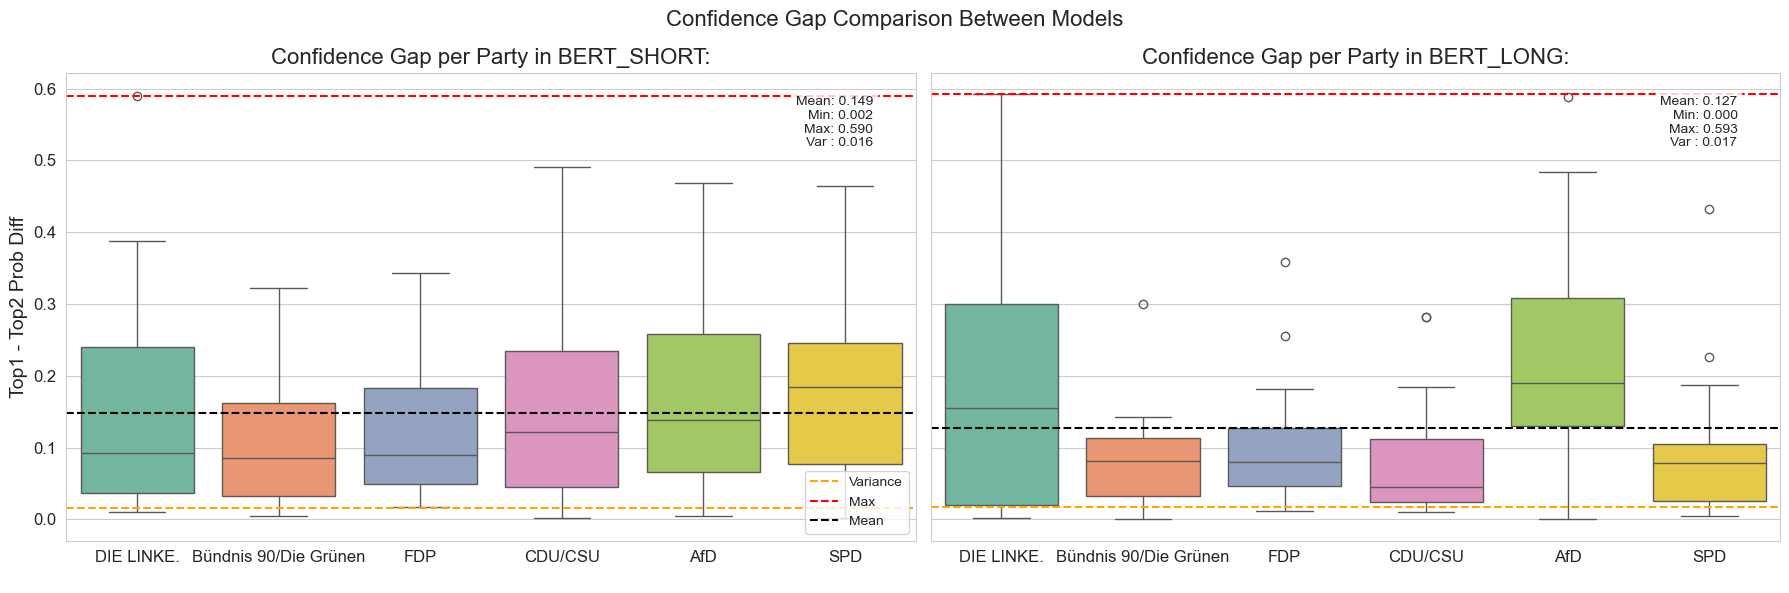

Top-k Hit Rate Overview:


,Top-1,Top-2,Top-3
BERT_SHORT,0.274,0.496,0.692
BERT_LONG,0.393,0.513,0.701


/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:644: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=topk_df.index, y=topk_df[metric], ax=ax, palette="viridis")
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:644: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=topk_df.index, y=topk_df[metric], ax=ax, palette="viridis")
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:644: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=topk

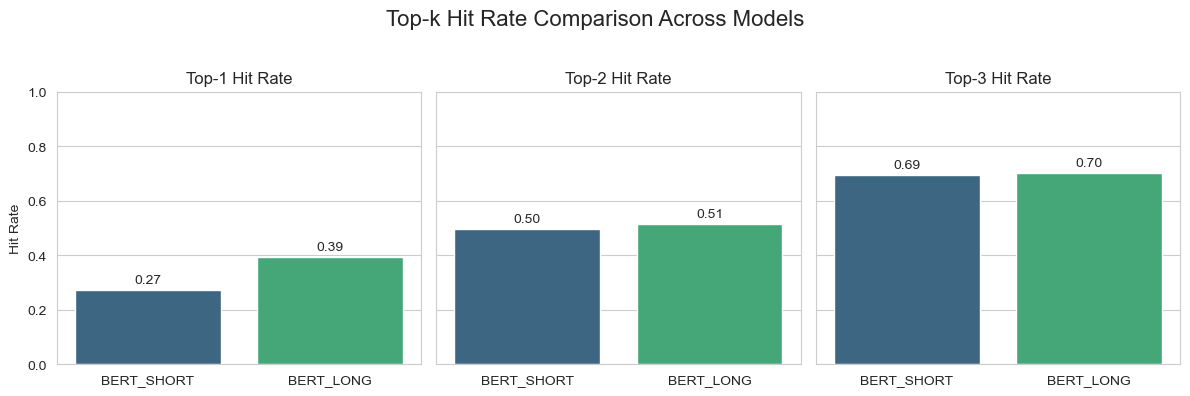

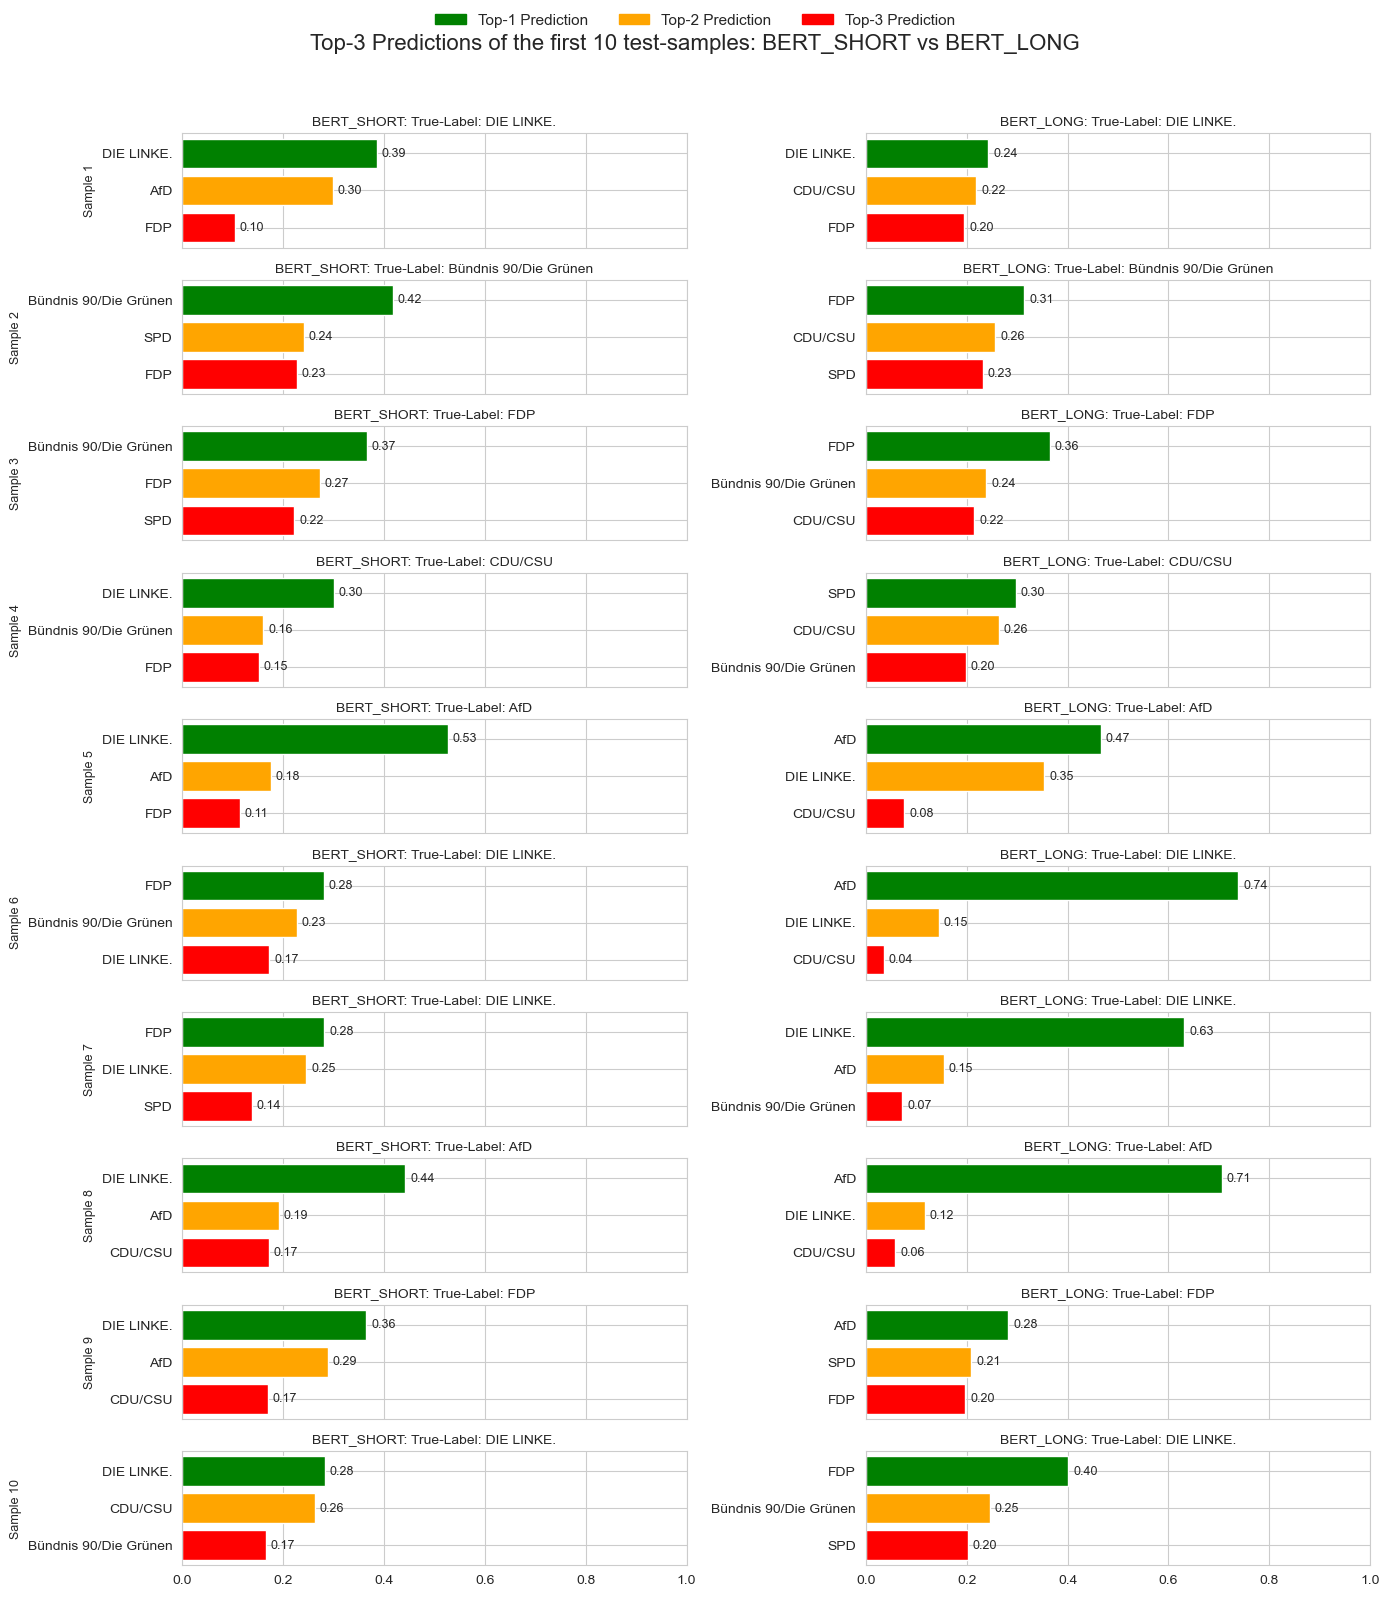


Classification Report SVM_SHORT:
                       precision  recall  f1-score  support
AfD                        0.333   0.333     0.333    48.00
Bündnis 90/Die Grünen      0.241   0.271     0.255    48.00
CDU/CSU                    0.333   0.327     0.330    49.00
DIE LINKE.                 0.167   0.184     0.175    49.00
FDP                        0.262   0.224     0.242    49.00
SPD                        0.174   0.163     0.168    49.00
accuracy                   0.250   0.250     0.250     0.25
macro avg                  0.252   0.250     0.251   292.00
weighted avg               0.251   0.250     0.250   292.00

Top 15 TF-IDF Features per Class – SVM_SHORT


,AfD,Bündnis 90/Die Grünen,CDU/CSU,DIE LINKE.,FDP,SPD
Rank,,,,,,
1,bürger,mehr,bitte schön,linke,gibt,kollegen
2,verstanden,syrer,bei den,die linke,grundlage,reden
3,ja was,in der,wir müssen,unter,die wirtschaft,reform
4,beenden,und so,klima,satz,woher,über
5,an die,unsere,unserem antrag,am,maskenpflicht,zu machen
6,energie,wir hier,natürlich,nicht mehr,entschuldigung,infrastruktur
7,her,förderung,unserem,leben,freiheit,arbeiten
8,dringend,zustimmen,angesichts,sie sich an,nämlich,hat die
9,wir sind,werden ich,danke herr,verhindert,unbedingt,dürfen



Classification Report SVM_LONG:
                       precision  recall  f1-score  support
AfD                        0.635   0.833     0.721   48.000
Bündnis 90/Die Grünen      0.442   0.396     0.418   48.000
CDU/CSU                    0.442   0.469     0.455   49.000
DIE LINKE.                 0.635   0.673     0.653   49.000
FDP                        0.548   0.469     0.505   49.000
SPD                        0.500   0.408     0.449   49.000
accuracy                   0.541   0.541     0.541    0.541
macro avg                  0.534   0.542     0.534  292.000
weighted avg               0.534   0.541     0.533  292.000

Top 15 TF-IDF Features per Class – SVM_LONG


,AfD,Bündnis 90/Die Grünen,CDU/CSU,DIE LINKE.,FDP,SPD
Rank,,,,,,
1,deutschland,menschen,sagen,linke,demokraten,mich
2,afd,innen,impfpflicht,die linke,vorratsdatenspeicherung,wir haben
3,bürger,menschenrechte,libanon,als linke,bin,dass wir
4,soll,müssen wir,lage,doch,etwas,zusammen
5,000,fossilen,herr minister,wir als linke,freie demokraten,noch mal
6,impfung,kein,deswegen,euro,bildung,haben wir
7,regierung,wolf,minister,muss,qualität,arbeitnehmerinnen und
8,für deutschland,taliban,wir als union,umbau,machen,arbeitnehmerinnen
9,partei,herdenschutz,heute,verbrenner,schritt,arbeit



=== Confusion Matrix for BERT_SHORT ===
Labels: [np.str_('AfD'), np.str_('Bündnis 90/Die Grünen'), np.str_('CDU/CSU'), np.str_('DIE LINKE.'), np.str_('FDP'), np.str_('SPD')]
True AfD: [6 1 3 8 1 0]
True Bündnis 90/Die Grünen: [2 8 3 1 3 2]
True CDU/CSU: [2 2 4 5 4 3]
True DIE LINKE.: [3 2 0 7 7 0]
True FDP: [5 4 2 3 4 2]
True SPD: [3 7 2 3 2 3]

=== Confusion Matrix for BERT_LONG ===
Labels: [np.str_('AfD'), np.str_('Bündnis 90/Die Grünen'), np.str_('CDU/CSU'), np.str_('DIE LINKE.'), np.str_('FDP'), np.str_('SPD')]
True AfD: [13  0  3  1  1  1]
True Bündnis 90/Die Grünen: [2 6 1 0 6 4]
True CDU/CSU: [1 5 6 1 4 3]
True DIE LINKE.: [1 2 8 6 2 0]
True FDP: [4 5 2 1 7 1]
True SPD: [2 3 2 0 5 8]

=== Confusion Matrix for SVM_SHORT ===
Labels: ['AfD', 'Bündnis 90/Die Grünen', 'CDU/CSU', 'DIE LINKE.', 'FDP', 'SPD']
True AfD: [16  7  7  6  4  8]
True Bündnis 90/Die Grünen: [ 5 13  4 13  8  5]
True CDU/CSU: [ 8  2 16 13  6  4]
True DIE LINKE.: [ 6  9  6  9  6 13]
True FDP: [ 9  8  8  5 11  8]


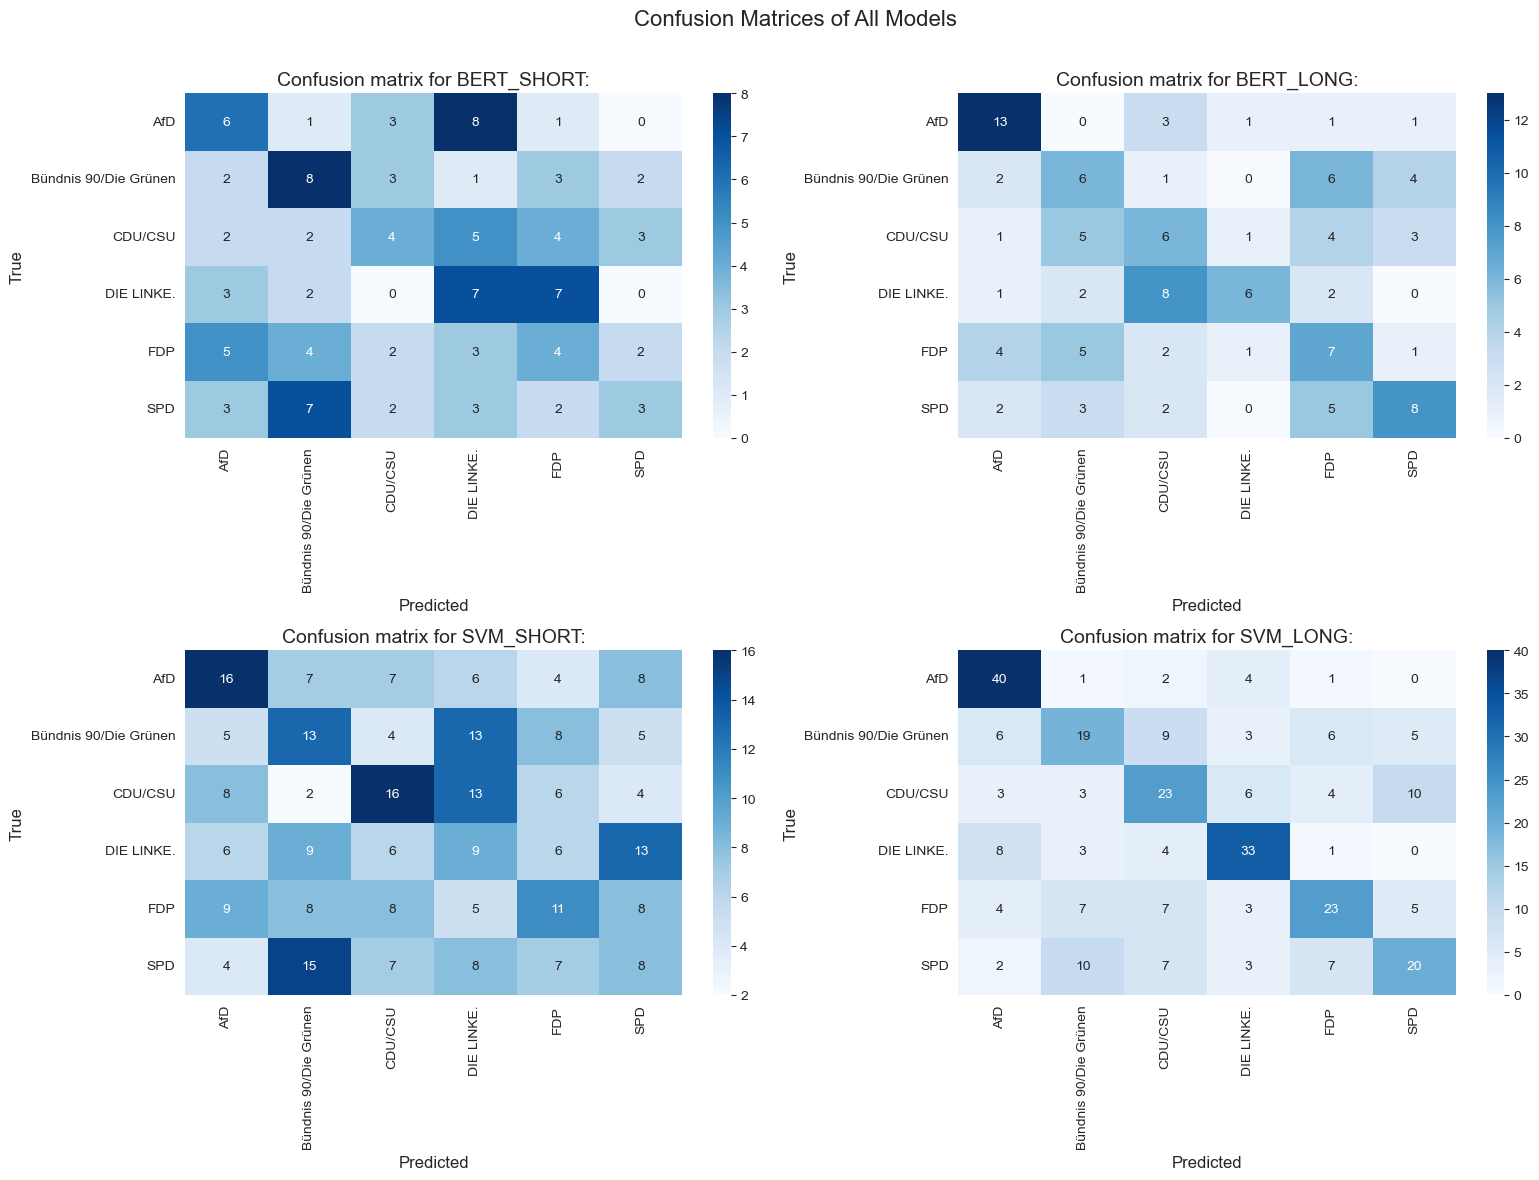

=== Per-Class Performance Metrics ===

Model: BERT_SHORT
  Class AfD:
    precision: 0.286
    recall: 0.316
    f1-score: 0.300
  Class Bündnis 90/Die Grünen:
    precision: 0.333
    recall: 0.421
    f1-score: 0.372
  Class CDU/CSU:
    precision: 0.286
    recall: 0.200
    f1-score: 0.235
  Class DIE LINKE.:
    precision: 0.259
    recall: 0.368
    f1-score: 0.304
  Class FDP:
    precision: 0.190
    recall: 0.200
    f1-score: 0.195
  Class SPD:
    precision: 0.300
    recall: 0.150
    f1-score: 0.200

Model: BERT_LONG
  Class AfD:
    precision: 0.565
    recall: 0.684
    f1-score: 0.619
  Class Bündnis 90/Die Grünen:
    precision: 0.286
    recall: 0.316
    f1-score: 0.300
  Class CDU/CSU:
    precision: 0.273
    recall: 0.300
    f1-score: 0.286
  Class DIE LINKE.:
    precision: 0.667
    recall: 0.316
    f1-score: 0.429
  Class FDP:
    precision: 0.280
    recall: 0.350
    f1-score: 0.311
  Class SPD:
    precision: 0.471
    recall: 0.400
    f1-score: 0.432

Mo

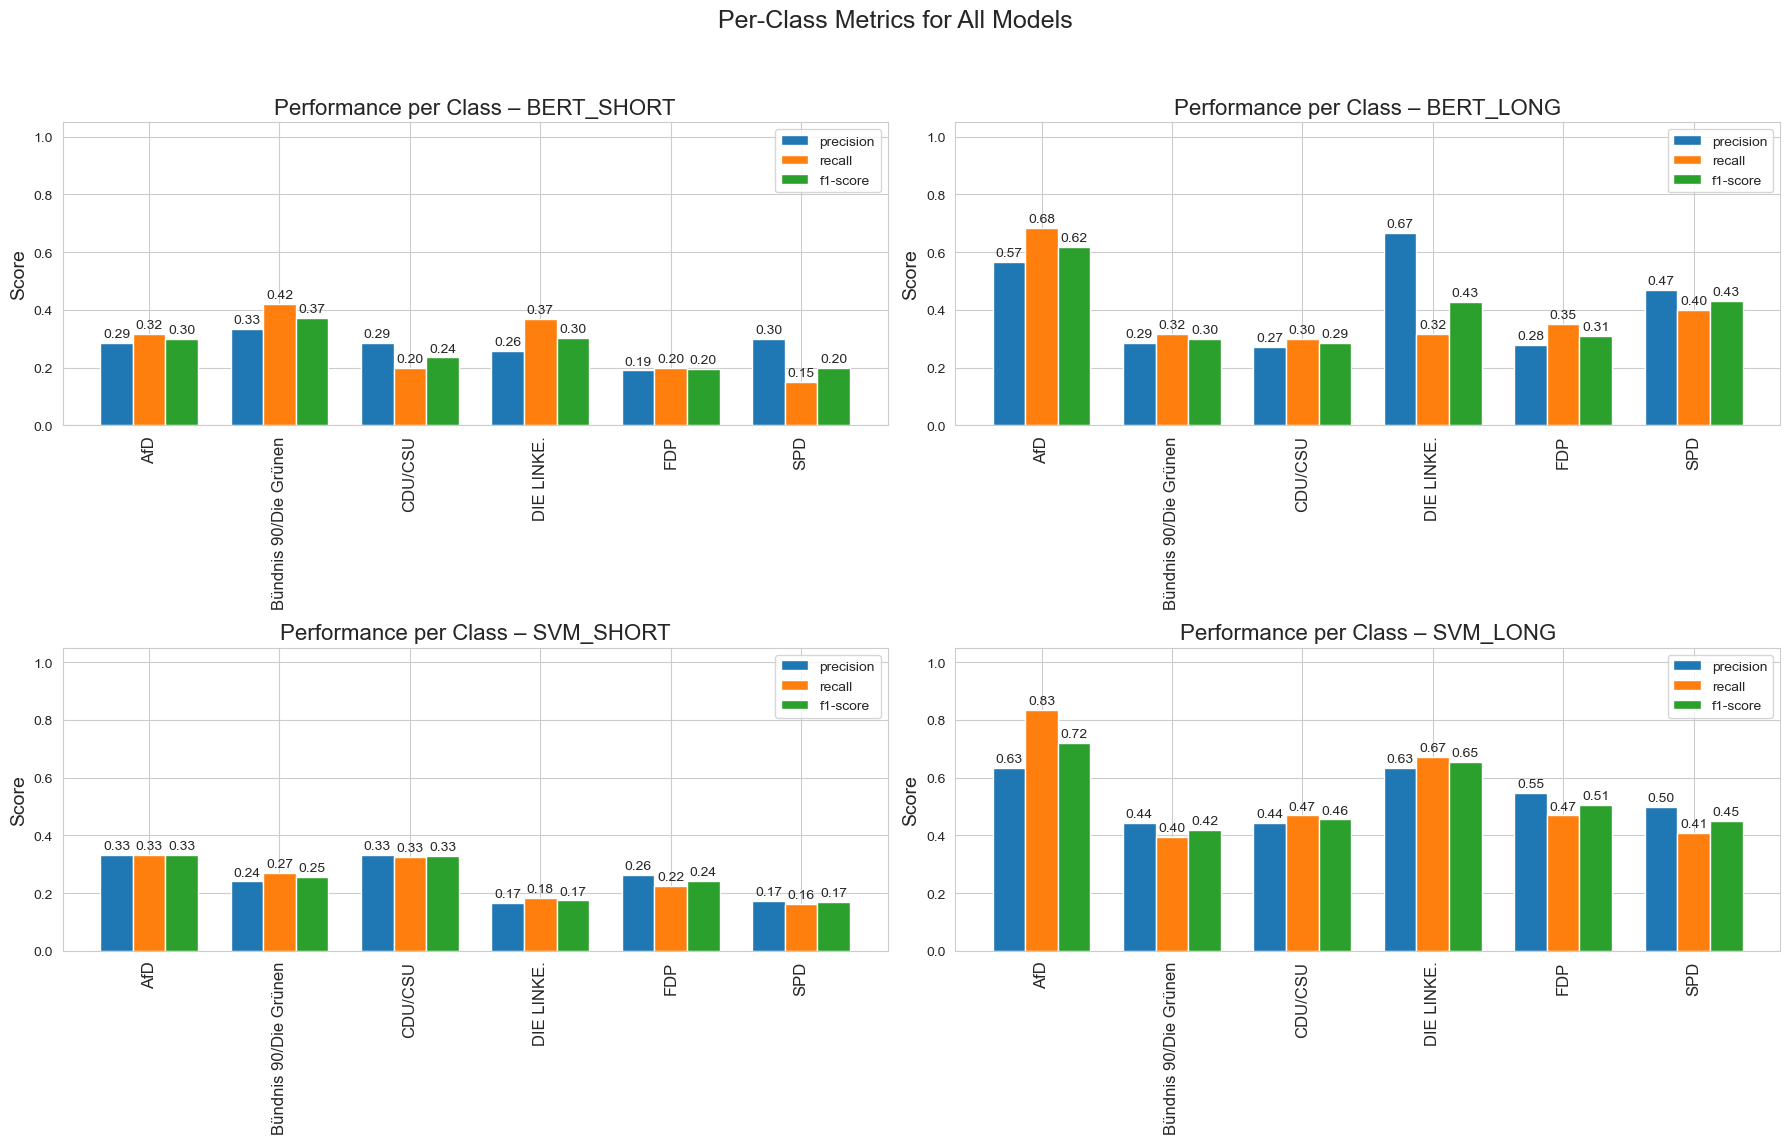


Summary of Classification Reports:


,Model,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,BERT_SHORT,0.274,0.268,0.276,0.276
1,BERT_LONG,0.393,0.396,0.423,0.394
2,SVM_SHORT,0.250,0.251,0.252,0.250
3,SVM_LONG,0.541,0.534,0.534,0.542


/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_57972/165374399.py:853: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=summary_df, palette="Set2")


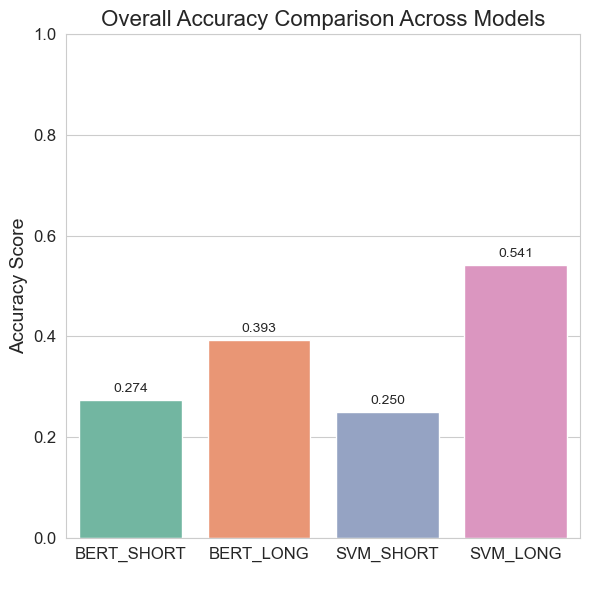

In [ ]:
"""
Setup constants
"""
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Model & Tokenizer
MODEL_NAME = "bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
LEARNING_RATE = 1e-5

# General settings
NUM_LABELS = 6  # will later also be adjustet based on the number of uniqe parties in the dataset
BATCH_SIZE = 8
EPOCHS = 3
MAX_SAMPLE_SIZE_PARTY=500
TEST_SPLIT_SIZE=0.2
MAX_LENGTH_SHORT = 128
MIN_LENGTH_LONG = 320
MAX_LENGTH_LONG = 512
MAX_FEATURES = 50000
NGRAM_RANGE = (1, 3)
MIN_DF = 3
MAX_DF = 0.5
TOP_N_FEATURES = 25



# Global dictionary to store all confusion matrices by model name
confusion_matrices = {}
# Global dictionary to collect classification reports per model
classification_reports = {}
# Global dictionary to collect top k hit rate for BERT models
topk_hit_rates = {}
# Stores the full df_top3 per model
df_top3_all = {}
# Load faction map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]



"""
Tokenization and dataset conversion
"""
def remove_contribution_markers(text: str) -> str:
    """
    - collapses whitespace
    - Removes content in square brackets like [Beifall], [Zwischenruf], etc.
    - Removes contribution position placeholders in the form of ({123})

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = re.sub(r'\[.*?\]', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'\(\{\d+\}\)', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def tokenize_function(examples, max_length):
    """
    Tokenizes input text using BertTokenizer with specific max token length.

    :param: examples (dict): Dictionary containing the key "speech_content" with raw text.
    :param: max_length (int): Maximum number of tokens after padding/truncation.

    :return: tokenized_output (dict): Dictionary with input_ids and attention masks.
    """
    return tokenizer(examples["speech_content"], padding="max_length", truncation=True, max_length=max_length)


def prepare_dataset(df_subset, max_len):
    """
    Prepares and tokenizes dataset from dataframe for BERT model training.

    :param: df_subset (pd.DataFrame): DataFrame containing speeches and encoded labels.
    :param: max_len (int): Maximum token length.

    :return: df_tokenized (Dataset): Tokenized and formatted dataset compatible with PyTorch.
    """
    df_subset["speech_content"] = df_subset["speech_content"].apply(remove_contribution_markers)
    df_dataset = Dataset.from_pandas(df_subset[["speech_content", "label_encoded"]])
    df_tokenized = df_dataset.map(lambda x: tokenize_function(x, max_len), batched=True)
    df_tokenized = df_tokenized.rename_column("label_encoded", "labels")

    cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in df_tokenized.column_names:
        cols.append("token_type_ids")
    df_tokenized.set_format(type="torch", columns=cols)
    return df_tokenized



def train_bert(train_ds_local, test_ds_local, eval_ds_local, test_df_local, model_name):
    """
    Training Loop for BERT

    :dependencies: transformers, sklearn, pandas, torch, seaborn, matplotlib, numpy, datasets, umap-learn

    :param: train_ds_local (Dataset): Tokenized training dataset.
    :param: test_ds_local (Dataset): Tokenized testing dataset.
    :param: test_df_local (DataFrame): Original dataframe of test set (needed for attention visualization).
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    # Initialize BERT model and trainer and move to device
    model_local = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    model_local.to(device)

    # Set training arguments for the HuggingFace trainer
    training_args_local = TrainingArguments(
        do_eval=True,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        seed=SEED,
        eval_strategy="epoch",
        save_strategy="no",
        disable_tqdm=False
    )

    # Trainer object initialization
    trainer_local = Trainer(
        model=model_local,
        args=training_args_local,
        train_dataset=train_ds_local,
        eval_dataset=eval_ds_local,
        tokenizer=tokenizer,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=-1)),
            "macro_f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=-1), average="macro")
        }
    )

    # train model
    trainer_local.train()

    # Predicting and decoding labels
    preds = trainer_local.predict(test_ds_local)
    y_true_local = encoder.inverse_transform(preds.label_ids)
    y_pred_local = encoder.inverse_transform(np.argmax(preds.predictions, axis=1))

    # Map to faction abbreviations
    y_true_abbr = [faction_map.get(label, str(label)) for label in y_true_local]
    y_pred_abbr = [faction_map.get(label, str(label)) for label in y_pred_local]

    # unique labels and abbr
    unique_labels=sorted(np.unique(y_true_local))
    unique_abbr=sorted(np.unique(y_true_abbr))


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true_local, y_pred_local, labels=unique_labels)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }


    # Classification Report
    report = classification_report(
        y_true_local,
        y_pred_local,
        target_names=[faction_map.get(fid, str(fid)) for fid in unique_labels],
        digits=3,
        output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report
    # Also: print report summary
    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))


    # Extract probabilities of top 3 predictions
    probs_local = torch.softmax(torch.tensor(preds.predictions), dim=1)
    top3_probs_local, top3_preds_local = probs_local.topk(3, dim=1)
    # Map top predictions to faction abbreviations
    top3_labels_abbr = np.vectorize(faction_map.get)((encoder.inverse_transform(top3_preds_local.numpy().flatten())).reshape(top3_preds_local.shape))

    # Create DataFrame of top 3 predictions with faction abbreviations clearly labeled
    df_top3 = pd.DataFrame({
        'True_Label': y_true_abbr,
        'Top1_Pred': top3_labels_abbr[:, 0],
        'Top1_Prob': top3_probs_local[:, 0].numpy(),
        'Top2_Pred': top3_labels_abbr[:, 1],
        'Top2_Prob': top3_probs_local[:, 1].numpy(),
        'Top3_Pred': top3_labels_abbr[:, 2],
        'Top3_Prob': top3_probs_local[:, 2].numpy(),
    })
    # Calculate confidence Gap
    df_top3["Confidence_Gap"] = df_top3["Top1_Prob"] - df_top3["Top2_Prob"]
    # Store complete DataFrame for this model
    df_top3_all[model_name] = df_top3.copy()

    # Draw random samples for report and plot
    print(f"\nZehn zufällige Top-3 predictions {model_name}:")
    top3_sample_df = df_top3.sample(10, random_state=SEED).reset_index(drop=True)
    display(top3_sample_df)
    print(f"Confidence Gap (mean) {model_name}:", df_top3["Confidence_Gap"].mean())
    print(f"Confidence Gap (min) {model_name}:", df_top3["Confidence_Gap"].min())
    print(f"Confidence Gap (max) {model_name}:", df_top3["Confidence_Gap"].max())
    print(f"Confidence Gap (var) {model_name}:", df_top3["Confidence_Gap"].var())

    """
    # Top-3 Prediction bar plots with abbreviations
    fig, axes = plt.subplots(nrows=10, figsize=(8, 10), sharex=True)
    for i, ax in enumerate(axes):
        labels = [top3_sample_df.loc[i, 'Top1_Pred'], top3_sample_df.loc[i, 'Top2_Pred'], top3_sample_df.loc[i, 'Top3_Pred']]
        probs = [top3_sample_df.loc[i, 'Top1_Prob'], top3_sample_df.loc[i, 'Top2_Prob'], top3_sample_df.loc[i, 'Top3_Prob']]
        ax.barh(labels, probs, color=["green", "orange", "red"])
        ax.set_xlim(0, 1)
        ax.set_title(f"True: {top3_sample_df.loc[i, 'True_Label']}", fontsize=9)
        ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    """

    def topk_hit_rate(df_top3, k):
        """
        Counts how often the true label appears in the top-k predictions.
        """
        hits = 0
        for i in range(len(df_top3)):
            true_label = df_top3.loc[i, 'True_Label']
            top_k_preds = [df_top3.loc[i, f'Top{j}_Pred'] for j in range(1, k+1)]
            if true_label in top_k_preds:
                hits += 1
        return hits / len(df_top3)

    # store top-k hit rates to plot later
    topk_hit_rates[model_name] = {
        "Top-1": topk_hit_rate(df_top3, 1),
        "Top-2": topk_hit_rate(df_top3, 2),
        "Top-3": topk_hit_rate(df_top3, 3)
    }
    # print summary of top-k hit rates now
    print(f"Top-1 Hit Rate {model_name}: {topk_hit_rate(df_top3, 1):.3f}")
    print(f"Top-2 Hit Rate {model_name}: {topk_hit_rate(df_top3, 2):.3f}")
    print(f"Top-3 Hit Rate {model_name}: {topk_hit_rate(df_top3, 3):.3f}")



    """
    # Heatmap: True Label vs. Top-3 Predictions (with abbreviations)
    heatmap_df = (
        df_top3.melt(id_vars="True_Label",
                     value_vars=["Top1_Pred", "Top2_Pred", "Top3_Pred"],
                     var_name="Rank", value_name="Predicted_Label")
        .groupby(["True_Label", "Predicted_Label"])
        .size()
        .unstack(fill_value=0)
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Top-3 Predictions across True Labels (Faction Abbreviations)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Violinplot der Top-3 Wahrscheinlichkeiten
    df_melted = df_top3.melt(id_vars="True_Label",
                             value_vars=["Top1_Prob", "Top2_Prob", "Top3_Prob"],
                             var_name="Rank", value_name="Probability")
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="Rank", y="Probability", data=df_melted, palette="Set2")
    plt.title("Probability Distribution by Prediction Rank")
    plt.tight_layout()
    plt.show()
    """

    """
    # Sankey-Diagramm der Übergänge (True → Top1)
    # Prepare data for Sankey Diagram with abbreviations
    sankey_data = (
        df_top3.groupby(['True_Label', 'Top1_Pred'])
        .size()
        .reset_index(name='count')
    )

    # Unique classes as nodes
    all_labels = list(set(sankey_data['True_Label']).union(sankey_data['Top1_Pred']))
    label_to_idx = {label: idx for idx, label in enumerate(all_labels)}

    # Map labels to indices
    sankey_data['source'] = sankey_data['True_Label'].map(label_to_idx)
    sankey_data['target'] = sankey_data['Top1_Pred'].map(label_to_idx)

    # Build Sankey-Diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color="blue"
        ),
        link=dict(
            source=sankey_data['source'],
            target=sankey_data['target'],
            value=sankey_data['count']
        ))])

    fig.update_layout(title_text="Top-1 Predictions vs. True Labels (Sankey Diagram with Faction Abbreviations)", font_size=10)
    fig.show()
    """


    # Extract CLS embeddings for UMAP
    dataloader_local = DataLoader(test_ds_local, batch_size=BATCH_SIZE)
    embeddings, labels = [], []

    # get embeddings
    model_local.eval()
    with torch.no_grad():
        for curr_batch in dataloader_local:
            inputs = {k: v.to(device) for k, v in curr_batch.items() if k != "labels"}
            curr_outputs = model_local.bert(**inputs)
            cls_embed = curr_outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embed)
            labels.extend(curr_batch["labels"].numpy())
    embeddings, labels = np.vstack(embeddings), np.array(labels)

    # Reduce embeddings with UMAP
    umap_model = UMAP(random_state=SEED, target_metric='categorical')
    umap_local = umap_model.fit_transform(embeddings, labels)

    # Decode labels (from encoded class ids → faction_ids)
    faction_ids = encoder.inverse_transform(labels)
    # Map to abbreviations
    faction_abbreviations = [faction_map.get(fid, f"faction_{fid}") for fid in faction_ids]

    # UMAP embedding Visualization
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=umap_local[:,0], y=umap_local[:,1], hue=faction_abbreviations, palette="tab10")
    plt.title(f"UMAP Embeddings {model_name}:", fontsize=16)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Party")
    plt.show()



"""
Training Loop for SVM with TF-IDF
"""
def train_svm(train_df_current, test_df_current, model_name):
    """
    Trains an SVM classifier using a TF-IDF pipeline.

    :param: train_df_current (pd.DataFrame): Training DataFrame.
    :param: test_df_current (pd.DataFrame): Testing DataFrame.
    :param model_name (str): Identifier for logging and result visualization.

    :return: None

    :raises: ValueError: If data preprocessing fails or model training encounters inconsistent labels.
    """
    def turn_lower_case(text: str) -> str:
        """
        Normalizes text to lowercase and collapses whitespace for TF-IDF vectorization

        :param text (str): Raw speech text
        :return text (str): Normalized speech text
        """
        if not isinstance(text, str):
            return text  # Skip non-string entries (if any)
        text = text.lower()
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    # normalize dataset to lowercase for less sparse TF-IDF vectors (copying to remove SettingWithCopyWarning)
    train_df_current = train_df_current.copy()
    test_df_current = test_df_current.copy()
    train_df_current["speech_content"] = train_df_current["speech_content"].apply(turn_lower_case)
    test_df_current["speech_content"] = test_df_current["speech_content"].apply(turn_lower_case)
    train_df_current["speech_content"] = train_df_current["speech_content"].apply(remove_contribution_markers)
    test_df_current["speech_content"] = test_df_current["speech_content"].apply(remove_contribution_markers)


    # Define TF-IDF & SVM pipeline and train the classifier
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF)),
        ("clf", LinearSVC(random_state=SEED))
    ])
    pipeline.fit(train_df_current["speech_content"], train_df_current["faction_id"])

    # predict
    y_pred_current = pipeline.predict(test_df_current["speech_content"])
    y_true_current = test_df_current["faction_id"]

    # Mapping for Abbreviations
    label_ids = sorted(np.unique(y_true_current))
    label_names_local = [faction_map.get(fid, str(fid)) for fid in label_ids]
    y_pred_abbr = [faction_map.get(fid, str(fid)) for fid in y_pred_current]
    y_true_abbr = [faction_map.get(fid, str(fid)) for fid in y_true_current]


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true_abbr, y_pred_abbr, labels=label_names_local)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": label_names_local
    }


    # Classification Report
    report = classification_report( y_true_abbr,
                                    y_pred_abbr,
                                    target_names=label_names_local,
                                    digits=3,
                                    output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report
    # Also: print report summary
    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))


    """
    # Top-15 TF-IDF Features per Class (print as table)
    print(f"\nTop 15 TF-IDF Features per Class – {model_name}")
    feature_names = pipeline.named_steps["tfidf"].get_feature_names_out()
    coef = pipeline.named_steps["clf"].coef_
    # Iteration over parties
    for i, label in enumerate(pipeline.named_steps["clf"].classes_):
        topn = np.argsort(coef[i])[-15:][::-1]  # most informative first
        label_abbr = faction_map.get(label, str(label))
        top_features = [(rank + 1, feature_names[j], coef[i][j]) for rank, j in enumerate(topn)]
        df_top = pd.DataFrame(top_features, columns=["Rank", "Feature", "Weight"])
        print(f"\nTop 15 Features für Klasse: '{label_abbr}'")
        display(df_top.style.format({"Weight": "{:.4f}"}))
    """


    # Top-15 TF-IDF Features per Class – Combined Table Format
    print(f"\nTop 15 TF-IDF Features per Class – {model_name}")
    feature_names = pipeline.named_steps["tfidf"].get_feature_names_out()
    coef = pipeline.named_steps["clf"].coef_
    classes = pipeline.named_steps["clf"].classes_

    # Dictionary to hold features per class
    feature_dict = {}

    # Fill dictionary: key = class_abbr, value = list of top 15 features
    for i, label in enumerate(classes):
        label_abbr = faction_map.get(label, str(label))
        topn = np.argsort(coef[i])[-15:][::-1]
        top_features = [feature_names[j] for j in topn]
        feature_dict[label_abbr] = top_features

    # Create DataFrame: rows = Rank, columns = Party Abbreviations
    df_combined = pd.DataFrame(feature_dict)
    df_combined.index = [f"{i+1}" for i in range(15)]
    df_combined.index.name = "Rank"

    # Display nicely formatted
    display(df_combined.style.set_caption(f"Top 15 TF-IDF Features per Party – {model_name}"))



"""
Load and filter data
"""
# Load faction map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]

# Load full raw dataset with raw speech text and faction_id
df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_20)
# Drop rows with missing labels or empty text
df = df[df["faction_id"] != -1].dropna(subset=["speech_content"])
# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()
df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.
# add abbreviations to data set
df["faction_abbreviation"] = df["faction_id"].map(faction_map)

# encode labels (necessary for good BERT classification)
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["faction_id"])
NUM_LABELS = len(encoder.classes_)

# Enable tqdm for pandas apply
tqdm.pandas(desc="Counting tokens")
# Token count via tokenizer with progress bar
def token_count(text):
    return len(tokenizer.tokenize(text))
df["token_count"] = df["speech_content"].progress_apply(token_count)

# Filter: SHORT (<128 Tokens) and LONG (320–512 Tokens)
df_short = df[df["token_count"] < MAX_LENGTH_SHORT]
df_long = df[(df["token_count"] >= MIN_LENGTH_LONG) & (df["token_count"] <= MAX_LENGTH_LONG)]
# Logging: Number of speeches per faction before sampling
print("\n[INFO] Distribution of short speeches (<128 tokens) before sampling:")
print(df_short["faction_abbreviation"].value_counts().sort_index())
print("\n[INFO] Distribution of long speeches (320–512 tokens) before sampling:")
print(df_long["faction_abbreviation"].value_counts().sort_index())

# find minimum sample size per party
MIN_SAMPLES = min(
    df_short.groupby("faction_id").size().min(),
    df_long.groupby("faction_id").size().min(),
    MAX_SAMPLE_SIZE_PARTY  # Cap to x per party
)
print(f"\n[INFO] Distribution of speeches AFTER sampling (for all models): {MIN_SAMPLES} speeches per class.")

# Stratified sample per set (same number of speeches per party)
df_short_sample = df_short.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=MIN_SAMPLES, random_state=SEED))
df_long_sample = df_long.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=MIN_SAMPLES, random_state=SEED))
# Logging: Number of speeches per faction after sampling
# print("\n[INFO] Distribution of short speeches AFTER sampling:")
# print(df_short_sample["faction_abbreviation"].value_counts().sort_index())
# print("\n[INFO] Distribution of long speeches AFTER sampling:")
# print(df_long_sample["faction_abbreviation"].value_counts().sort_index())



"""
Unified Train-Test Split for BERT and SVM Models
"""
# Perform stratified split once for short and long speech samples
train_df_short, test_df_short = train_test_split(
    df_short_sample,
    stratify=df_short_sample["label_encoded"],
    test_size=TEST_SPLIT_SIZE,
    random_state=SEED
)

train_df_long, test_df_long = train_test_split(
    df_long_sample,
    stratify=df_long_sample["label_encoded"],
    test_size=TEST_SPLIT_SIZE,
    random_state=SEED
)

# Split temst into val + test for BERT models
val_df_short_bert, test_df_short_bert = train_test_split(
    test_df_short,
    test_size=0.4,
    stratify=test_df_short["label_encoded"],
    random_state=SEED
)
val_df_long_bert, test_df_long_bert = train_test_split(
    test_df_long,
    test_size=0.4,
    stratify=test_df_long["label_encoded"],
    random_state=SEED
)



"""
Start BERT training
"""
# Set device type explicitly for MPS (Apple Silicon), CUDA or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Tokenization and training for BERT_SHORT
train_ds_short_bert = prepare_dataset(train_df_short, MAX_LENGTH_SHORT)
test_ds_short_bert = prepare_dataset(test_df_short_bert, MAX_LENGTH_SHORT)
eval_ds_short_bert = prepare_dataset(val_df_short_bert, MAX_LENGTH_SHORT)
train_bert(train_ds_short_bert, test_ds_short_bert, eval_ds_short_bert,  test_df_short_bert, "BERT_SHORT")

# Tokenization and training for BERT_LONG
train_ds_long_bert = prepare_dataset(train_df_long, MAX_LENGTH_LONG)
test_ds_long_bert = prepare_dataset(test_df_long_bert, MAX_LENGTH_SHORT)
eval_ds_long_bert = prepare_dataset(val_df_long_bert, MAX_LENGTH_SHORT)
train_bert(train_ds_long_bert, test_ds_long_bert, eval_ds_long_bert, test_df_long_bert, "BERT_LONG")



"""
Plot 1x2: Confidence Gap per model
"""
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
for i, (model_name, df_top3_model) in enumerate(df_top3_all.items()):
    sns.boxplot(x="True_Label", y="Confidence_Gap", data=df_top3_model, palette="Set2", ax=axes[i])
    axes[i].set_title(f"Confidence Gap per Party in {model_name}:", fontsize=16)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].tick_params(axis='both', labelsize=12)
    axes[i].set_ylabel("Top1 - Top2 Prob Diff" if i == 0 else "", fontsize=14)
    axes[i].set_xlabel(" ")

    # Compute statistics
    gap_mean = df_top3_model["Confidence_Gap"].mean()
    gap_min = df_top3_model["Confidence_Gap"].min()
    gap_max = df_top3_model["Confidence_Gap"].max()
    gap_var = df_top3_model["Confidence_Gap"].var()

    # Insert stats as annotation
    stats_text = (
        f"Mean: {gap_mean:.3f}\n"
        f"Min: {gap_min:.3f}\n"
        f"Max: {gap_max:.3f}\n"
        f"Var : {gap_var:.3f}"
    )

    axes[i].text(0.95, 0.95,
                 stats_text,
                 transform=axes[i].transAxes, ha="right", va="top",
                 fontsize=10, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

    # dodded lines for variance and max-/mean-value
    axes[i].axhline(gap_var, linestyle='--', color='orange', linewidth=1.5, label="Variance")
    axes[i].axhline(gap_max, linestyle='--', color='red', linewidth=1.5, label="Max")
    axes[i].axhline(gap_mean, linestyle='--', color='black', linewidth=1.5, label="Mean")

    # Show legend only in first plot
    if i == 0:
        axes[i].legend(loc="lower right")

# show plot
plt.suptitle("Confidence Gap Comparison Between Models", fontsize=16)
plt.tight_layout()
plt.show()



"""
Plot 1x3 (Top-1, Top-2, Top-3): Top-k Hit Rates per model
"""
# Convert to DataFrame
topk_df = pd.DataFrame(topk_hit_rates).T  # rows = models, columns = Top-1, Top-2, Top-3
print("Top-k Hit Rate Overview:")
display(topk_df.style.format("{:.3f}").set_caption("Top-k Hit Rates per Model"))

# Barplot Top-k Hit Rates pro Modell
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for i, metric in enumerate(["Top-1", "Top-2", "Top-3"]):
    ax = axes[i]
    barplot = sns.barplot(x=topk_df.index, y=topk_df[metric], ax=ax, palette="viridis")
    ax.set_ylim(0, 1)
    ax.set_title(f"{metric} Hit Rate")
    ax.set_ylabel("Hit Rate")
    ax.set_xlabel("")

    # bar_label
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

# show plot
plt.suptitle("Top-k Hit Rate Comparison Across Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



"""
Comparison: Top-3 Prediction Plots of the first 10 examples of each model side by side
"""
# Choose Models
models_to_compare = ["BERT_SHORT", "BERT_LONG"]
# Get the Top-10 Samples of both models
sample_data = {
    model: df_top3_all[model].head(10).reset_index(drop=True)
    for model in models_to_compare
}
# Generates Subplots: 10 rows, 2 columns (one per model)
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 16), sharex=True)

# Define colors and their meaning
colors = ["green", "orange", "red"]
labels_legend = ["Top-1 Prediction", "Top-2 Prediction", "Top-3 Prediction"]

for row in range(10):
    for col, model in enumerate(models_to_compare):
        ax = axes[row, col]
        row_data = sample_data[model].loc[row]

        pred_labels = [row_data['Top1_Pred'], row_data['Top2_Pred'], row_data['Top3_Pred']]
        pred_probs = [row_data['Top1_Prob'], row_data['Top2_Prob'], row_data['Top3_Prob']]

        bars = ax.barh(pred_labels, pred_probs, color=colors)
        ax.set_xlim(0, 1)
        ax.invert_yaxis()

        # Add probability value at end of each bar
        for bar, prob in zip(bars, pred_probs):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f"{prob:.2f}", va='center', fontsize=9)

        # Label only on the left side
        if col == 0:
            ax.set_ylabel(f"Sample {row + 1}", fontsize=9)

        # True label in the title
        ax.set_title(f"{model}: True-Label: {row_data['True_Label']}", fontsize=10)

# Global title
plt.suptitle("Top-3 Predictions of the first 10 test-samples: BERT_SHORT vs BERT_LONG", fontsize=16)
# Legend
legend_patches = [mpatches.Patch(color=clr, label=lbl) for clr, lbl in zip(colors, labels_legend)]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, frameon=False, fontsize=11)
# show full plot
plt.tight_layout(rect=(0, 0, 1, 0.96))  # leave space for title and legend
plt.show()



"""
Start SVM training with shared splits
"""
# Training on short speeches
train_svm(train_df_short, test_df_short, "SVM_SHORT")

# Training on long speeches
train_svm(train_df_long, test_df_long, "SVM_LONG")



"""
Shared 2×2 Confusion Matrix Grid Plot
"""
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_grid = [
    ["BERT_SHORT", "BERT_LONG"],
    ["SVM_SHORT", "SVM_LONG"]
]

for i in range(2):
    for j in range(2):
        model_name = model_grid[i][j]
        if model_name in confusion_matrices:
            cm_data = confusion_matrices[model_name]

            # Plot heatmap
            sns.heatmap(cm_data["matrix"], annot=True, fmt="d", cmap="Blues",
                        xticklabels=cm_data["labels"],
                        yticklabels=cm_data["labels"],
                        ax=axes[i, j])
            axes[i, j].set_title(f"Confusion matrix for {model_name}:", fontsize=14)
            axes[i, j].set_xlabel("Predicted", fontsize=12)
            axes[i, j].set_ylabel("True", fontsize=12)
            axes[i, j].tick_params(labelsize=10)

            # Print textual matrix
            print(f"\n=== Confusion Matrix for {model_name} ===")
            print("Labels:", cm_data["labels"])
            for true_label, row in zip(cm_data["labels"], cm_data["matrix"]):
                print(f"True {true_label}: {row}")

        else:
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{model_name} (not available)")

plt.suptitle("Confusion Matrices of All Models", fontsize=16)
plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()



"""
Compare data from classification reports
"""
# Define metrics to compare
metrics = ["precision", "recall", "f1-score"]
n_models = len(classification_reports)

# Print per-class scores in stdout
print("=== Per-Class Performance Metrics ===")
for model_name, report in classification_reports.items():
    print(f"\nModel: {model_name}")
    class_keys = [k for k in report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
    for cls in class_keys:
        print(f"  Class {cls}:")
        for metric in metrics:
            print(f"    {metric}: {report[cls][metric]:.3f}")

# Create subplot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Colors for the bars per metric
colors = {"precision": "tab:blue", "recall": "tab:orange", "f1-score": "tab:green"}

for idx, (model_name, report) in enumerate(classification_reports.items()):
    ax = axes[idx]

    # extract classes (ohne avg/accuracy keys)
    class_keys = [k for k in report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]

    # prepare plotbars
    x = np.arange(len(class_keys))
    bar_width = 0.25

    for i, metric in enumerate(metrics):
        heights = [report[cls][metric] for cls in class_keys]
        bars = ax.bar(x + i * bar_width, heights, width=bar_width, label=metric, color=colors[metric])

        # write values above bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
                    ha='center', va='bottom', fontsize=10)

    # x-ticks and Styling
    ax.set_title(f"Performance per Class – {model_name}", fontsize=16)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(class_keys, rotation=90, fontsize=12)
    ax.set_yticks(np.linspace(0, 1, 6))  # Optional: besser lesbar
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score", fontsize=14)
    ax.legend()

plt.suptitle("Per-Class Metrics for All Models", fontsize=18)
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()



"""
Print summary table of all classification reports
"""
# Build summary table from all classification reports
summary_data = []

for model_name, report in classification_reports.items():
    row = {
        "Model": model_name,
        "Accuracy": report.get("accuracy", np.nan),
        "Macro-F1": report.get("macro avg", {}).get("f1-score", np.nan),
        "Macro-Precision": report.get("macro avg", {}).get("precision", np.nan),
        "Macro-Recall": report.get("macro avg", {}).get("recall", np.nan)
    }
    summary_data.append(row)

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Round for better readability
summary_df = summary_df.round(3)

# Display as table
print("\nSummary of Classification Reports:")
display(summary_df)


# Additional Plot: copare accuracy per model
plt.figure(figsize=(6, 6))
sns.barplot(x="Model", y="Accuracy", data=summary_df, palette="Set2")
plt.ylim(0, 1)
plt.title("Overall Accuracy Comparison Across Models", fontsize=16)
plt.ylabel("Accuracy Score", fontsize=14)
plt.xlabel(" ")
plt.tick_params(labelsize=12)

# write values over bars
for i, row in summary_df.iterrows():
    plt.text(i, row["Accuracy"] + 0.01, f"{row['Accuracy']:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

## **Results and Observations**

**Objective Recap:** This experiment investigates whether the length of a parliamentary speech — as a proxy for available semantic context — affects the ability of machine learning models to accurately predict the political party affiliation of the speaker. Both transformer-based models (BERT) and classical models (SVM with TF-IDF) are compared under identical data splits and settings.


---


### **Overall Performance Comparison: LONG vs. SHORT:**

| Model      | Input Length   | Accuracy | Macro-F1 | Top-3 Hit Rate |
|------------|----------------|----------|----------|----------------|
| BERT_SHORT | <128 tokens    | 31.6 %   | 0.303    | 67.5 %         |
| BERT_LONG  | 320–512 tokens | 43.6 %   | 0.429    | 71.8 %         |
| SVM_SHORT  | <128 tokens    | 25.0 %   | 0.251    | –              |
| SVM_LONG   | 320–512 tokens | 54.1 %   | 0.534    | –              |

**Observation:**
- Longer speeches consistently result in better classification performance across both BERT and SVM. While `SVM_SHORT` performs worse than `BERT_SHORT` but `SVM_LONG` surprisingly outperforms `BERT_LONG` in both accuracy and macro-F1, which is notable given its simplicity. This suggests that in well-preprocessed, high-context settings, traditional models remain competitive.
- SVM_SHORT and BERT_SHORT struggle to surpass baseline performance and exhibit severe underfitting, highlighting the semantic insufficiency of short speeches.


---


### **Class-wise Performance (Recall):**

| Class            | BERT_SHORT | BERT_LONG | SVM_SHORT | SVM_LONG |
|------------------|------------|-----------|-----------|----------|
| AfD              | 37 %       | 74 %      | 33 %      | 41 %     |
| Bündnis 90/Grüne | 53 %       | 21 %      | 27 %      | 47 %     |
| CDU/CSU          | 02 %       | 30 %      | 33 %      | 67 %     |
| DIE LINKE.       | 47 %       | 37 %      | 18 %      | 47 %     |
| FDP              | 25 %       | 55 %      | 22 %      | 40 %     |
| SPD              | 10 %       | 45 %      | 16 %      | 83 %     |

**Observation:**
- Long input consistently improves recall for **all classes**.
- The strongest relative improvements are observed for **SPD** and **AfD**, especially in the SVM model.
- `BERT_SHORT` fails particularly on SPD (only 10 % recall), likely due to lacking ideological context in short procedural speeches.
- Per-Class Analysis Highlights
    - `BERT_LONG` performs notably better for AfD and DIE LINKE., both of which have ideologically distinctive language patterns.
    - `SVM_LONG` shows the strongest results for AfD and DIE LINKE., further confirming the role of longer context in preserving class-separability.


---


### **Confusion Matrices (Visual Error Analysis):**

- **BERT Models:**
    - BERT_SHORTs matrix shows considerable scatter. The model struggles with confusion (especially between ideologically adjacent parties e.g. Grüne ↔ FDP), indicating that short utterances lack discriminative content.
    - BERT_LONG shows far clearer diagonal structure in the matrix with better separation between most parties, indicating improved class separability.
- **SVM Models:**
    - SVM_SHORT appears highly dispersed (very noisy matrix), indicating poor separability of all parties. Almost all parties confuse with all others.
    - SVM_LONG performs surprisingly well, with strong diagonals especially for AfD, CDU, and DIE LINKE.
    - SVM_LONG even surpasses BERT_LONG in most class-level predictions, which is notable given the difference in model complexity.


---


### **Confidence Gap & Hit Rate Analysis (BERT):**

| Model          | Confidence Gap (Mean) | Variance | Top-1 Hit Rate | Top-2 Hit Rate | Top-3 Hit Rate |
|----------------|-----------------------|----------|----------------|----------------|----------------|
| **BERT_SHORT** | 0.071                 | 0.003    | 31.6 %         | 49.6 %         | 67.5 %         |
| **BERT_LONG**  | 0.087                 | 0.006    | 43.6 %         | 59.8 %         | 71.8 %         |

**Interpretation: Confidence Gap:**
- BERT_SHORT’s narrow and low confidence distribution implies that the model remains uncertain and indecisive, likely due to lack of party-unique signals in short inputs.
- BERT_LONG exhibits both higher average confidence and greater variance, suggesting it can better differentiate between classes because sufficient context is available.

**Interpretation: Hit Rate:**
- Even when not correctly predicting the top class, BERT_LONG's Top-3 predictions frequently contain the correct party, indicating learned semantic proximity and more robust embeddings.
- In `BERT_SHORT`, Top-3 predictions often include **parties ideologically adjacent to the true label**. This suggests that the model picks up weak rhetorical signals but lacks strong disambiguators.
- In `BERT_LONG`, Top-1 predictions are more often correct, and Top-2/3 provide plausible alternatives (e.g., DIE LINKE predicted 1st, SPD 2nd).


---


### **Lexical Feature Analysis (SVM): Top 15 TF-IDF Features per Class**

- **SVM_SHORT:** **Top TF-IDF terms** are often procedural, generic or neutral phrases-.
- **SVM_LONG:** **Top TF-IDF terms** show clearer ideologically meaningful terms (e.g., "klimakrise", "werte kollegen", "afd fraktion", "freiheit", "ausbildungsgarantie")

→ The shift confirms the hypothesis that short speeches lack distinctive, party-relevant language, while longer ones are rich in content-specific and ideologically polarized terms, making them much more distinguishable for linear models.


---


## **Conclusion**

- Both **accuracy** and **class-level consistency** substantially improve with longer speech input — not just due to token count, but because of the semantic richness and ideological signal they carry. Removing very short samples would improve model focus and generalization.
- BERT_LONG and SVM_LONG both benefit from extended context and perform comparably, but SVM_LONG surprisingly excels due to feature sparsity and well-separated vocabulary.
- Top TF-IDF terms are absent in short texts: Filtered Datasets with longer speeches would preserve more semantic signal for classic machine learning models
- All in all, we could boost model confidence and reduce inter-class confusion by removing too short inputs. We also have to note that the BERT_SHORT model needed much less time to train than BERT_LONG (the difference in training time between the two SVM models was insignificant).

**Take Away:** Short speeches should be filtered in future pipelines.

**The experiment confirms the hypothesis:**
> Longer speeches provide richer semantic context, enabling both deep and classic models to better capture party-specific language patterns.


---


Back to [`ML-Task-1: Classification`](ML-Task-1_Classification.ipynb) ...